In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('Animal_Shelter_Intake_and_Outcome_20240517.csv')

In [3]:
df.columns

Index(['Name', 'Type', 'Breed', 'Color', 'Sex', 'Size', 'Date Of Birth',
       'Impound Number', 'Kennel Number', 'Animal ID', 'Intake Date',
       'Outcome Date', 'Days in Shelter', 'Intake Type', 'Intake Subtype',
       'Outcome Type', 'Outcome Subtype', 'Intake Condition',
       'Outcome Condition', 'Intake Jurisdiction', 'Outcome Jurisdiction',
       'Outcome Zip Code', 'Location', 'Count'],
      dtype='object')

## Lets remove spaces to make coding easier

In [4]:
col_list = []
for col in df.columns:
    col = col.replace(' ', '_')
    col_list.append(col)
df.columns = col_list
df.columns

Index(['Name', 'Type', 'Breed', 'Color', 'Sex', 'Size', 'Date_Of_Birth',
       'Impound_Number', 'Kennel_Number', 'Animal_ID', 'Intake_Date',
       'Outcome_Date', 'Days_in_Shelter', 'Intake_Type', 'Intake_Subtype',
       'Outcome_Type', 'Outcome_Subtype', 'Intake_Condition',
       'Outcome_Condition', 'Intake_Jurisdiction', 'Outcome_Jurisdiction',
       'Outcome_Zip_Code', 'Location', 'Count'],
      dtype='object')

## What should we do with missing data?

In [5]:
for col in df.columns:
    null_count = df[col][df[col].isnull()].shape[0]
    if null_count!= 0:
        print(f'{col} has null rows: {null_count}')

Name has null rows: 7317
Size has null rows: 36
Date_Of_Birth has null rows: 6822
Kennel_Number has null rows: 10
Outcome_Date has null rows: 256
Outcome_Type has null rows: 262
Outcome_Subtype has null rows: 594
Outcome_Condition has null rows: 616
Outcome_Jurisdiction has null rows: 4005
Outcome_Zip_Code has null rows: 4027
Location has null rows: 4027


## days in shelter is right skewed

In [6]:
df.describe()

,Days_in_Shelter,Outcome_Zip_Code,Count
count,27839.000000,23812.000000,27839.000000
mean,19.196235,95012.310264,0.994253
std,36.619929,3796.793126,0.075594
min,0.000000,1922.000000,0.000000
25%,1.000000,95401.000000,1.000000
50%,9.000000,95404.000000,1.000000
75%,24.000000,95425.000000,1.000000
max,1239.000000,99701.000000,1.000000


<Axes: ylabel='Frequency'>

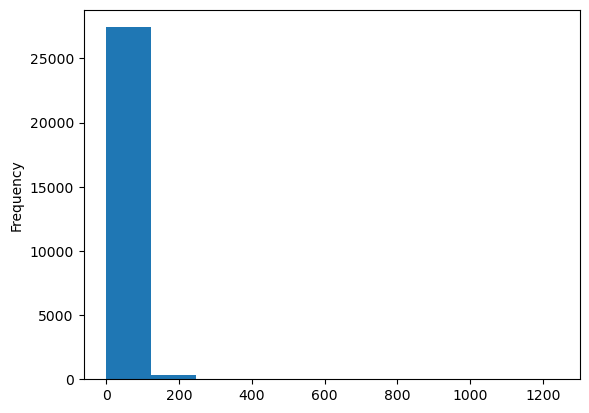

In [11]:
df.Days_in_Shelter.plot.hist()

## Animal Gender

In [ ]:
df.Sex.unique()

## Animal Breed

In [ ]:
print(f'there are {len(df.Breed.unique())} unique breeds')
cat_breed_count = len(df.Breed[df.Type=='CAT'].unique())
print(f'cat breeds: {cat_breed_count}')
dog_breed_count = len(df.Breed[df.Type=='DOG'].unique())
print(f'dog breeds: {dog_breed_count}')
Other_breed_count = len(df.Breed[df.Type=='OTHER'].unique())
print(f'other breeds: {Other_breed_count}')

In [ ]:
df[df.Type=='CAT'].Breed.value_counts()[0:8].plot.bar()
plt.title('CAT Breeds')

In [ ]:
df[df.Type=='DOG'].Breed.value_counts()[0:15].plot.bar()
plt.title('DOG Breeds')

## Animal Type

In [ ]:
df.Type.unique()

### What is the other type?

In [ ]:
df[df.Type=='OTHER'].Breed.unique()

### I think we should ignore other, all these different animal types add a lot of noise to the data

## Animal Size

In [ ]:
df[df.Type=='CAT'].Size.value_counts().plot.bar()
plt.title('CAT Sizes')

In [ ]:
df[df.Type=='DOG'].Size.value_counts().plot.bar()
plt.title('DOG Sizes')

## What colors do we have?

In [ ]:
print(f'there are {len(df.Color.unique())} unique colors')
breed_color = len(df.Color[df.Type=='CAT'].unique())
print(f'cat colors: {breed_color}')
breed_color = len(df.Color[df.Type=='DOG'].unique())
print(f'dog colors: {breed_color}')
breed_color = len(df.Color[df.Type=='OTHER'].unique())
print(f'other colors: {breed_color}')
print()
print(df.Color.value_counts())

In [ ]:
df[df.Type=='DOG'].Color.value_counts()[:20].plot.bar()
plt.title('DOG colors')

In [ ]:
df[df.Type=='CAT'].Color.value_counts()[:20].plot.bar()
plt.title('cat colors')

## Intake Type is skewed

Text(0.5, 1.0, 'intake type')

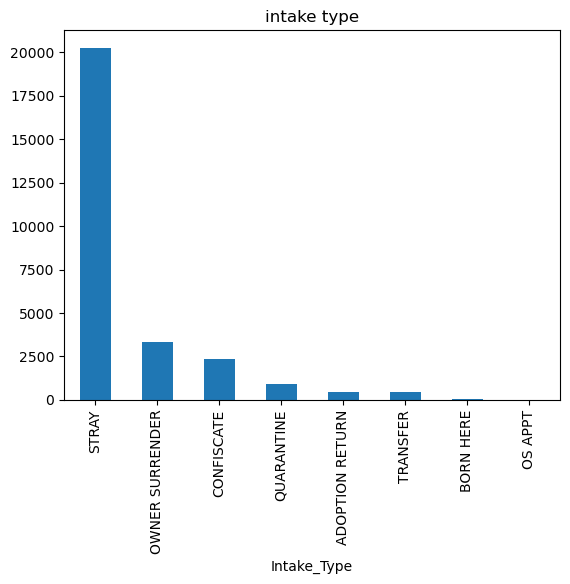

In [14]:
df.Intake_Type.value_counts().plot.bar()
plt.title('intake type')

Text(0.5, 1.0, 'intake subtype')

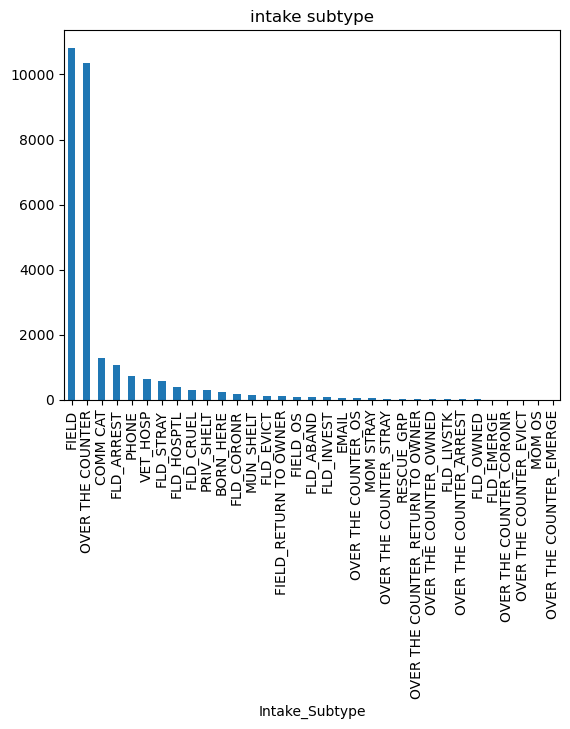

In [22]:
df.Intake_Subtype.value_counts().plot.bar()
plt.title('intake subtype')

## Most animals are not euthanized, but there are still a lot of animals in this category

Text(0.5, 1.0, 'Outcome type')

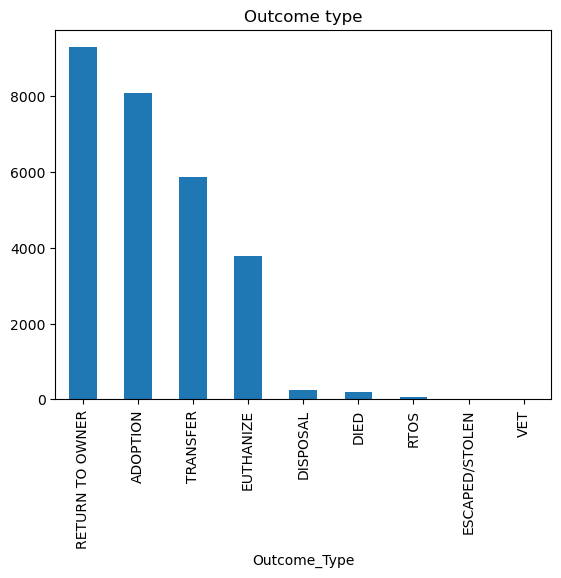

In [16]:
df.Outcome_Type.value_counts().plot.bar()
plt.title('Outcome type')

## outcome subtype has so many options. could be interesting to use NLP here

In [20]:
len(df.Outcome_Subtype.unique())

244

Text(0.5, 1.0, 'Outcome subtype')

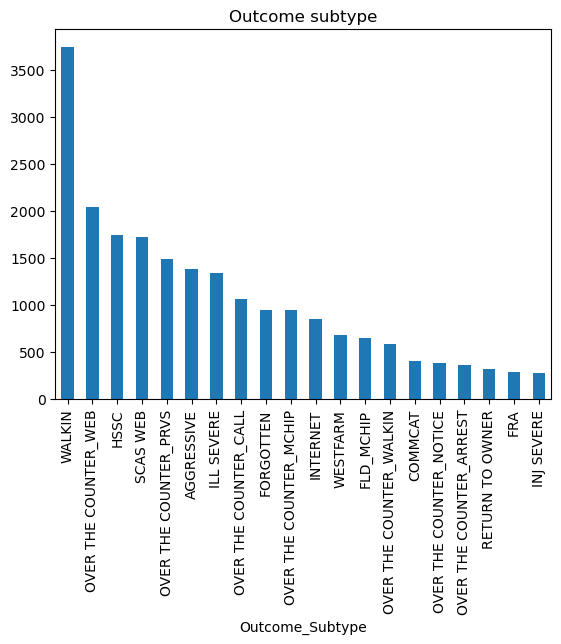

In [18]:
df.Outcome_Subtype.value_counts()[:20].plot.bar()
plt.title('Outcome subtype')

## most animals come in healthy, when is condition be unknown?

Text(0.5, 1.0, 'Intake_Condition')

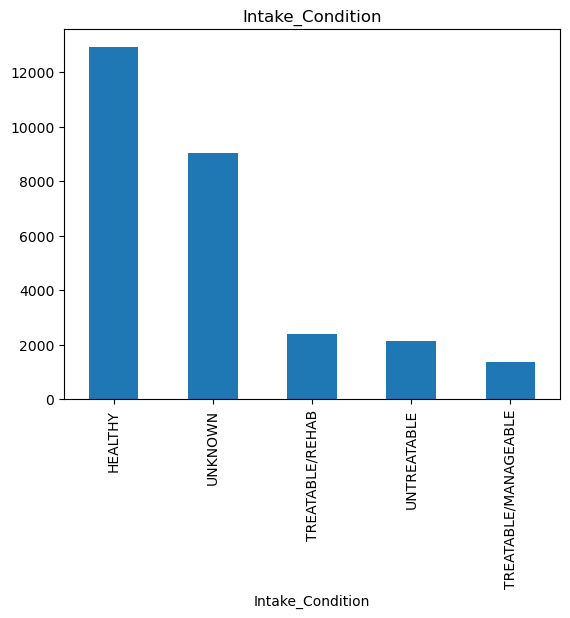

In [23]:
df.Intake_Condition.value_counts()[:20].plot.bar()
plt.title('Intake_Condition')

## it appears going to a shelter usually improves health

what does pending mean?

Text(0.5, 1.0, 'Outcome_Condition')

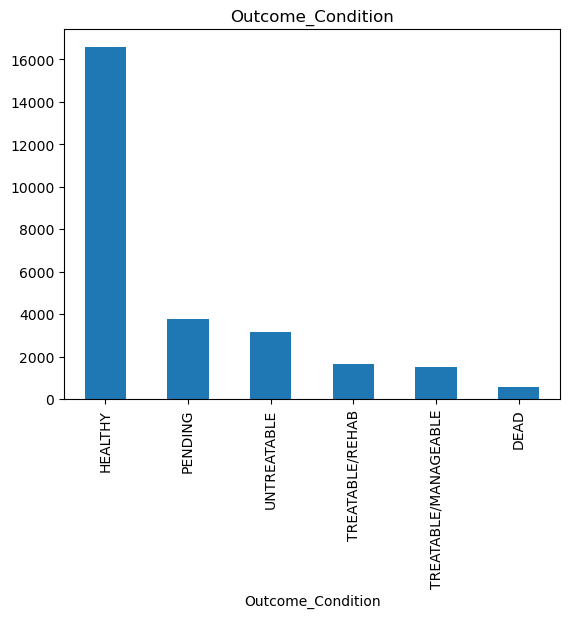

In [26]:
df.Outcome_Condition.value_counts()[:20].plot.bar()
plt.title('Outcome_Condition')

## Thoughts
There are many categories for breed, color and outcome subtype. Perhaps too many. We may need to feature engineer these columns to group similar colors